In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 24751.29it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

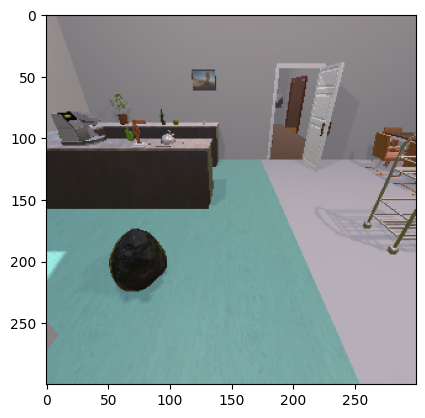

In [3]:
import matplotlib.pyplot as plt
event = controller.step("MoveAhead")
plt.imshow(event.frame)

In [4]:
event.metadata["agent"]["position"]

{'x': 3.5, 'y': 0.9009997844696045, 'z': 5.0}

In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty, load_actor_critic
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [6]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


In [11]:
from torchinfo import summary

summary(clip_actor_critic.actor), summary(clip_actor_critic.critic), summary(clip_actor_critic.actor_critic_encoder)

(==========================================================================================
 Layer (type:depth-idx)                                            Param #
 SlidingWindowTransformerActor                                     8,192
 ├─TransformerEncoder: 1-1                                         --
 │    └─ModuleList: 2-1                                            --
 │    │    └─TransformerEncoderLayer: 3-1                          789,760
 │    │    └─TransformerEncoderLayer: 3-2                          789,760
 │    │    └─TransformerEncoderLayer: 3-3                          789,760
 │    │    └─TransformerEncoderLayer: 3-4                          789,760
 ├─Linear: 1-2                                                     771
 Total params: 3,168,003
 Trainable params: 3,168,003
 Non-trainable params: 0
 ==========================================================================================,
 Layer (type:depth-idx)                                            Param #
 S

In [19]:
# load_actor_critic(clip_actor_critic, "data/Full Run/frozen resnet/complete_frozen_89.pt", device=DEVICE)
load_actor_critic(clip_actor_critic, "data/Full Run/frozen_resnet_low_lr/complete_frozen_low_lr.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/Full Run/frozen_resnet_low_lr/complete_frozen_low_lr.pt


In [21]:
from rl import PPO
import torch
from rl import inference_video_mp4, inference

def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    print(dist.probs)
    return dist


points = {
    "center_point": {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0},
    "trapped": {'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654},
    # "inside_room": {'x': 8.765543937683105, 'y': 0.9009993672370911, 'z': 6.941987037658691},
}

for i in range(4):
    for name, point in points.items():
        inference_video_mp4(get_distributions, controller, ppo, init_position=point, env=clip_env, actor_critic=clip_actor_critic, video_path=f"rollout{name}_{i}.mp4")

tensor([0.5289, 0.4606, 0.0105])
tensor([0.3014, 0.6912, 0.0074])
tensor([0.1895, 0.8040, 0.0065])
tensor([0.1779, 0.8169, 0.0052])
tensor([0.3289, 0.6662, 0.0050])
tensor([0.8769, 0.1196, 0.0035])
tensor([0.5780, 0.4162, 0.0059])
tensor([0.2351, 0.7597, 0.0053])
tensor([0.1869, 0.8087, 0.0044])
tensor([0.3410, 0.6536, 0.0054])
tensor([0.1836, 0.8113, 0.0051])
tensor([0.6038, 0.3890, 0.0072])
tensor([0.5162, 0.4774, 0.0065])
tensor([0.9471, 0.0502, 0.0027])
tensor([0.9706, 0.0272, 0.0022])
tensor([0.9707, 0.0261, 0.0031])
tensor([0.9604, 0.0374, 0.0022])
tensor([0.4673, 0.5273, 0.0053])
tensor([0.5242, 0.4727, 0.0031])
tensor([0.5304, 0.4652, 0.0045])
tensor([0.3704, 0.6253, 0.0043])
tensor([0.2791, 0.7162, 0.0047])
tensor([0.3994, 0.5919, 0.0087])
tensor([0.3262, 0.6674, 0.0064])
tensor([0.3173, 0.6747, 0.0081])
tensor([0.1355, 0.8588, 0.0056])
tensor([0.6901, 0.3055, 0.0043])
tensor([0.7893, 0.2057, 0.0050])
tensor([0.8686, 0.1275, 0.0040])
tensor([0.8508, 0.1458, 0.0034])
tensor([0.

tensor([0.1603, 0.7518, 0.0879])
tensor([0.1796, 0.7750, 0.0454])
tensor([0.2142, 0.7520, 0.0338])
tensor([0.2171, 0.7550, 0.0279])
tensor([0.2681, 0.7081, 0.0238])
tensor([0.4921, 0.4891, 0.0189])
tensor([0.2809, 0.6996, 0.0194])
tensor([0.2584, 0.7201, 0.0215])
tensor([0.5925, 0.3776, 0.0299])
tensor([0.3649, 0.6161, 0.0190])
tensor([0.3245, 0.6571, 0.0183])
tensor([0.4429, 0.5420, 0.0151])
tensor([0.2106, 0.7795, 0.0099])
tensor([0.4202, 0.5654, 0.0144])
tensor([0.6088, 0.3744, 0.0168])
tensor([0.3745, 0.6139, 0.0116])
tensor([0.0907, 0.9008, 0.0085])
tensor([0.0594, 0.9339, 0.0067])
tensor([0.0413, 0.9520, 0.0066])
tensor([0.0422, 0.9518, 0.0060])
tensor([0.1119, 0.8764, 0.0116])
tensor([0.0878, 0.9013, 0.0109])
tensor([0.0860, 0.9006, 0.0134])
tensor([0.1228, 0.8646, 0.0125])
tensor([0.0786, 0.9082, 0.0132])
tensor([0.1064, 0.8810, 0.0127])
tensor([0.1696, 0.8155, 0.0149])
tensor([0.0718, 0.9198, 0.0084])
tensor([0.4269, 0.5547, 0.0183])
tensor([0.6828, 0.3005, 0.0167])
tensor([0.

tensor([0.0618, 0.9354, 0.0029])
[🎞️] Saved video to rollouttrapped_0.mp4
tensor([0.4090, 0.5823, 0.0087])
tensor([0.2890, 0.7019, 0.0091])
tensor([0.6692, 0.3208, 0.0100])
tensor([0.9251, 0.0717, 0.0032])
tensor([0.8780, 0.1185, 0.0035])
tensor([0.8648, 0.1323, 0.0029])
tensor([0.8135, 0.1830, 0.0036])
tensor([0.8074, 0.1881, 0.0045])
tensor([0.8968, 0.1000, 0.0032])
tensor([0.9373, 0.0599, 0.0028])
tensor([0.8143, 0.1807, 0.0050])
tensor([0.8087, 0.1872, 0.0042])
tensor([0.8954, 0.1017, 0.0029])
tensor([0.9531, 0.0448, 0.0021])
tensor([0.8821, 0.1143, 0.0036])
tensor([0.9263, 0.0708, 0.0029])
tensor([0.8009, 0.1960, 0.0031])
tensor([0.5622, 0.4344, 0.0035])
tensor([0.6794, 0.3169, 0.0037])
tensor([0.4525, 0.5437, 0.0039])
tensor([0.8369, 0.1593, 0.0038])
tensor([0.6673, 0.3279, 0.0048])
tensor([0.4886, 0.5057, 0.0057])
tensor([0.2125, 0.7827, 0.0048])
tensor([0.4497, 0.5451, 0.0052])
tensor([0.3247, 0.6698, 0.0055])
tensor([0.2829, 0.7126, 0.0046])
tensor([0.3527, 0.6404, 0.0068])
te

[🎞️] Saved video to rolloutcenter_point_1.mp4
tensor([0.0910, 0.8698, 0.0392])
tensor([0.1161, 0.8529, 0.0310])
tensor([0.1484, 0.8242, 0.0274])
tensor([0.3172, 0.6409, 0.0419])
tensor([0.2017, 0.7651, 0.0332])
tensor([0.3396, 0.6367, 0.0237])
tensor([0.2800, 0.6984, 0.0217])
tensor([0.5441, 0.4305, 0.0255])
tensor([0.3753, 0.6043, 0.0205])
tensor([0.2444, 0.7218, 0.0338])
tensor([0.2166, 0.7616, 0.0219])
tensor([0.3447, 0.6350, 0.0203])
tensor([0.3900, 0.5874, 0.0226])
tensor([0.3131, 0.6697, 0.0172])
tensor([0.2936, 0.6832, 0.0232])
tensor([0.4035, 0.5822, 0.0143])
tensor([0.0570, 0.9346, 0.0084])
tensor([0.0451, 0.9471, 0.0078])
tensor([0.0533, 0.9351, 0.0115])
tensor([0.0504, 0.9387, 0.0109])
tensor([0.0615, 0.9266, 0.0119])
tensor([0.0992, 0.8859, 0.0149])
tensor([0.1810, 0.7979, 0.0211])
tensor([0.2216, 0.7597, 0.0187])
tensor([0.2057, 0.7749, 0.0194])
tensor([0.2370, 0.7472, 0.0158])
tensor([0.4250, 0.5509, 0.0240])
tensor([0.4941, 0.4837, 0.0222])
tensor([0.6332, 0.3443, 0.0225

tensor([0.8836, 0.1128, 0.0036])
[🎞️] Saved video to rollouttrapped_1.mp4
tensor([0.5163, 0.4769, 0.0068])
tensor([0.5494, 0.4417, 0.0089])
tensor([0.2062, 0.7865, 0.0074])
tensor([0.5625, 0.4304, 0.0071])
tensor([0.2097, 0.7849, 0.0055])
tensor([0.7728, 0.2215, 0.0057])
tensor([0.7832, 0.2130, 0.0038])
tensor([0.6322, 0.3620, 0.0058])
tensor([0.8039, 0.1904, 0.0058])
tensor([0.9089, 0.0877, 0.0035])
tensor([0.8807, 0.1158, 0.0035])
tensor([0.8991, 0.0964, 0.0045])
tensor([0.9424, 0.0549, 0.0026])
tensor([0.9383, 0.0589, 0.0028])
tensor([0.9619, 0.0357, 0.0024])
tensor([0.9519, 0.0458, 0.0023])
tensor([0.9309, 0.0667, 0.0024])
tensor([0.9338, 0.0632, 0.0029])
tensor([0.8860, 0.1115, 0.0026])
tensor([0.9116, 0.0857, 0.0027])
tensor([0.4865, 0.5078, 0.0057])
tensor([0.4737, 0.5209, 0.0054])
tensor([0.8252, 0.1698, 0.0050])
tensor([0.7416, 0.2512, 0.0072])
tensor([0.3332, 0.6594, 0.0074])
tensor([0.6289, 0.3659, 0.0052])
tensor([0.1975, 0.7971, 0.0054])
tensor([0.1914, 0.8034, 0.0053])
te

[🎞️] Saved video to rolloutcenter_point_2.mp4
tensor([0.1500, 0.8153, 0.0347])
tensor([0.1004, 0.8550, 0.0446])
tensor([0.1703, 0.7897, 0.0400])
tensor([0.2558, 0.7169, 0.0274])
tensor([0.4399, 0.5335, 0.0266])
tensor([0.3929, 0.5833, 0.0238])
tensor([0.2874, 0.6957, 0.0168])
tensor([0.2143, 0.7644, 0.0212])
tensor([0.4824, 0.4916, 0.0260])
tensor([0.3247, 0.6552, 0.0201])
tensor([0.4121, 0.5723, 0.0157])
tensor([0.2907, 0.6952, 0.0141])
tensor([0.3311, 0.6529, 0.0161])
tensor([0.1596, 0.8287, 0.0117])
tensor([0.0857, 0.9038, 0.0105])
tensor([0.0414, 0.9518, 0.0068])
tensor([0.0424, 0.9495, 0.0081])
tensor([0.0579, 0.9316, 0.0105])
tensor([0.1005, 0.8854, 0.0141])
tensor([0.1352, 0.8524, 0.0124])
tensor([0.1753, 0.8125, 0.0123])
tensor([0.1212, 0.8650, 0.0137])
tensor([0.2770, 0.7052, 0.0179])
tensor([0.3795, 0.6013, 0.0192])
tensor([0.2808, 0.7022, 0.0170])
tensor([0.2170, 0.7634, 0.0196])
tensor([0.4816, 0.5008, 0.0176])
tensor([0.7711, 0.2106, 0.0183])
tensor([0.9113, 0.0756, 0.0131

tensor([0.8923, 0.1049, 0.0028])
[🎞️] Saved video to rollouttrapped_2.mp4
tensor([0.4990, 0.4927, 0.0082])
tensor([0.2320, 0.7628, 0.0052])
tensor([0.1808, 0.8144, 0.0048])
tensor([0.3728, 0.6222, 0.0050])
tensor([0.4821, 0.5110, 0.0070])
tensor([0.7361, 0.2575, 0.0064])
tensor([0.5005, 0.4940, 0.0056])
tensor([0.4803, 0.5138, 0.0059])
tensor([0.7033, 0.2899, 0.0068])
tensor([0.6954, 0.2985, 0.0062])
tensor([0.7656, 0.2292, 0.0051])
tensor([0.7044, 0.2894, 0.0063])
tensor([0.8759, 0.1199, 0.0042])
tensor([0.9509, 0.0453, 0.0037])
tensor([0.9818, 0.0160, 0.0022])
tensor([0.9788, 0.0183, 0.0029])
tensor([0.9173, 0.0784, 0.0043])
tensor([0.8001, 0.1963, 0.0036])
tensor([0.2372, 0.7592, 0.0036])
tensor([0.2524, 0.7434, 0.0042])
tensor([0.1634, 0.8326, 0.0040])
tensor([0.2620, 0.7327, 0.0054])
tensor([0.9305, 0.0655, 0.0040])
tensor([0.9347, 0.0613, 0.0040])
tensor([0.9591, 0.0370, 0.0039])
tensor([0.7632, 0.2318, 0.0050])
tensor([0.8080, 0.1886, 0.0034])
tensor([0.8183, 0.1768, 0.0049])
te

tensor([0.8830, 0.1140, 0.0030])
[🎞️] Saved video to rolloutcenter_point_3.mp4
tensor([0.1857, 0.7554, 0.0589])
tensor([0.1694, 0.7838, 0.0469])
tensor([0.1423, 0.8045, 0.0532])
tensor([0.1894, 0.7704, 0.0402])
tensor([0.2235, 0.7510, 0.0254])
tensor([0.2311, 0.7387, 0.0302])
tensor([0.3153, 0.6545, 0.0303])
tensor([0.3092, 0.6709, 0.0199])
tensor([0.5148, 0.4482, 0.0370])
tensor([0.2959, 0.6702, 0.0339])
tensor([0.1748, 0.8047, 0.0205])
tensor([0.3802, 0.5904, 0.0294])
tensor([0.2869, 0.6936, 0.0195])
tensor([0.4412, 0.5335, 0.0253])
tensor([0.4474, 0.5273, 0.0253])
tensor([0.2320, 0.7508, 0.0172])
tensor([0.1128, 0.8733, 0.0140])
tensor([0.0412, 0.9477, 0.0111])
tensor([0.0524, 0.9362, 0.0114])
tensor([0.0567, 0.9333, 0.0100])
tensor([0.0751, 0.9099, 0.0149])
tensor([0.0672, 0.9184, 0.0143])
tensor([0.2155, 0.7556, 0.0289])
tensor([0.1628, 0.8120, 0.0251])
tensor([0.1240, 0.8559, 0.0201])
tensor([0.3024, 0.6770, 0.0207])
tensor([0.4247, 0.5470, 0.0283])
tensor([0.4630, 0.5148, 0.0222

In [9]:
from models import SmallCNNEncoder

ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = SmallCNNEncoder(FEAT_DIM, device=DEVICE)
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)

In [10]:
load_actor_critic(clip_actor_critic, "data/Full Run/cnn_scratch/cnn_scratch_69.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/Full Run/cnn_scratch/cnn_scratch_69.pt


In [11]:
import torch
from rl import inference_video_mp4, inference

def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    return dist


points = {
    # "center_point": {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0},
    # "trapped": {'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654},
    "inside_room": {'x': 8.765543937683105, 'y': 0.9009993672370911, 'z': 6.941987037658691},
}

for i in range(4):
    for name, point in points.items():
        inference_video_mp4(get_distributions, controller, ppo, init_position=point, env=clip_env, actor_critic=clip_actor_critic, video_path=f"rollout{name}_{i}.mp4")

[🎞️] Saved video to rolloutinside_room_0.mp4


[🎞️] Saved video to rolloutinside_room_1.mp4


[🎞️] Saved video to rolloutinside_room_2.mp4
[🎞️] Saved video to rolloutinside_room_3.mp4


In [259]:
event.metadata["agent"]["position"]

{'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654}

In [11]:
controller.stop()